# Pneumonia Diagnosis

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd 

## Explore the dataset 

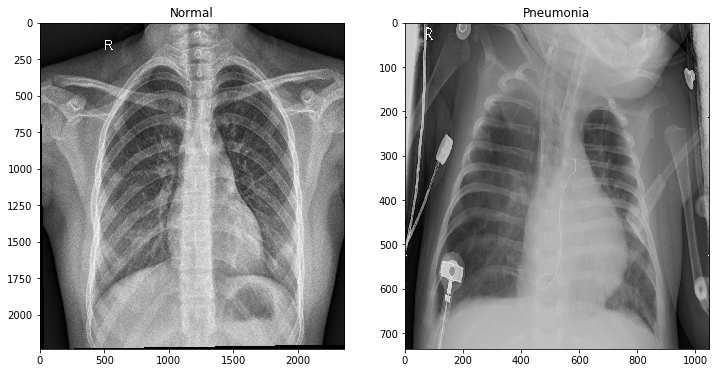

In [2]:
img_normal = plt.imread("data/train/NORMAL/NORMAL2-IM-0927-0001.jpeg")
img_pneumonia = plt.imread("data/train/PNEUMONIA/person63_bacteria_306.jpeg")

fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].imshow(img_normal, cmap="gray", aspect="auto")
ax[0].title.set_text('Normal')

ax[1].imshow(img_pneumonia, cmap="gray", aspect="auto")
ax[1].title.set_text('Pneumonia')

plt.show()

In [3]:
img_normal.shape, img_pneumonia.shape

((2234, 2359), (736, 1048))

## Preprocess Images

In [150]:
rescale = 1./255
batch_size = 64
target_size = (224, 224)

train_datagen = ImageDataGenerator(
        rescale=rescale,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=rescale)
test_datagen = ImageDataGenerator(rescale=rescale)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=True)

validation_generator = valid_datagen.flow_from_directory(
        'data/test',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=True)

test_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=True)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Initialize the Model

In [5]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# we need to recompile the model for these modifications to take effect
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=["acc"])

## Training Phase

In [7]:
steps_per_epoch = train_generator.samples / train_generator.batch_size
validation_steps = validation_generator.samples / validation_generator.batch_size 

early_stop = EarlyStopping(monitor='val_acc', patience=5)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=[early_stop])

Epoch 1/10
82/81 [==============================] - 178s 2s/step - loss: 0.1588 - acc: 0.9358 - val_loss: 1.3031 - val_acc: 0.6811
Epoch 2/10
82/81 [==============================] - 149s 2s/step - loss: 0.0701 - acc: 0.9712 - val_loss: 1.2347 - val_acc: 0.7051
Epoch 3/10
82/81 [==============================] - 149s 2s/step - loss: 0.0572 - acc: 0.9787 - val_loss: 0.9826 - val_acc: 0.7692
Epoch 4/10
82/81 [==============================] - 150s 2s/step - loss: 0.0342 - acc: 0.9875 - val_loss: 0.6683 - val_acc: 0.8317
Epoch 5/10
82/81 [==============================] - 150s 2s/step - loss: 0.0358 - acc: 0.9856 - val_loss: 0.4164 - val_acc: 0.8974
Epoch 6/10
82/81 [==============================] - 151s 2s/step - loss: 0.0275 - acc: 0.9896 - val_loss: 0.3297 - val_acc: 0.9087
Epoch 7/10
82/81 [==============================] - 150s 2s/step - loss: 0.0296 - acc: 0.9898 - val_loss: 0.2089 - val_acc: 0.9375
Epoch 8/10
82/81 [==============================] - 150s 2s/step - loss: 0.0177 - a

## Evaluate the model

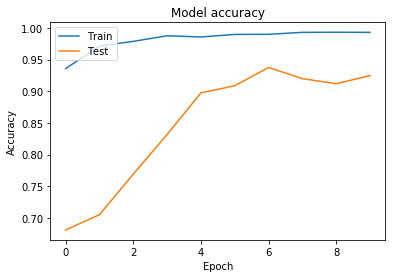

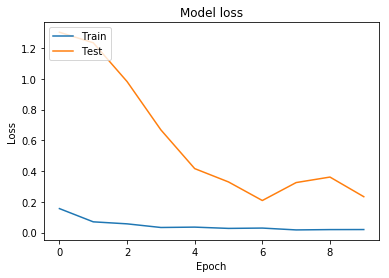

In [8]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model.save("saved_model.h5")

In [0]:
idx2label = dict((i, l) for l, i in train_generator.class_indices.items())
sample = validation_generator.next()

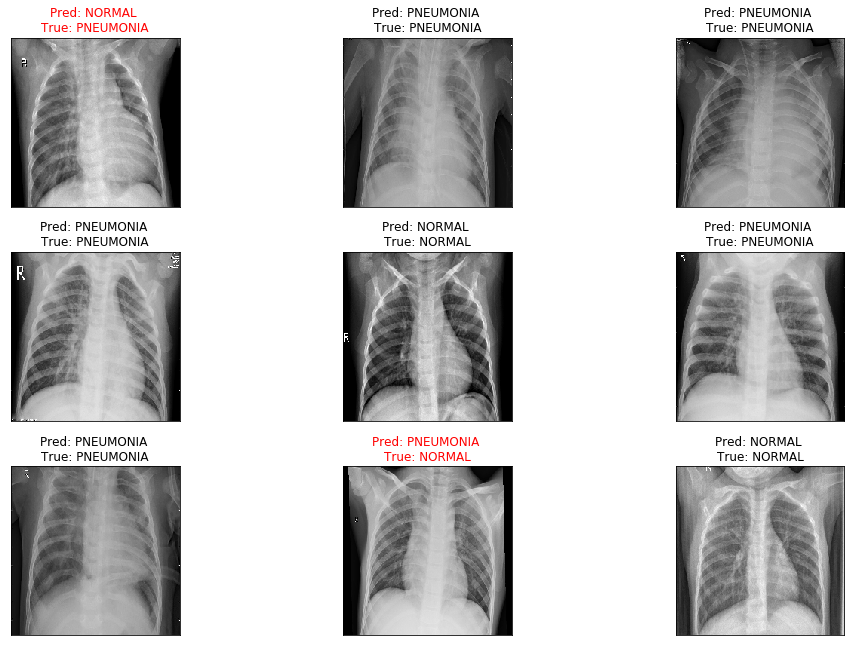

In [152]:
fig = plt.figure(figsize=(14,12))

for idx in range(9):
  
  test_img = np.expand_dims(sample[0][idx], 0)
  test_label = np.argmax(sample[1][idx])
  
  pred = model.predict(test_img)
  
  topclass = np.argmax(pred)
  
  pred_label = idx2label[topclass]
  true_label = idx2label[test_label]
  
  color = "black"
  
  if pred_label != true_label:
    color = "red"
  
  fig.add_subplot(4, 3, idx+1)
  plt.imshow(np.squeeze(test_img))
  plt.title("Pred: {} \nTrue: {}".format(pred_label, true_label), color=color)
  
  plt.xticks([])
  plt.yticks([])


plt.tight_layout()  
plt.show()